In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from sargas import *
import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
import glob
import re
from collections import namedtuple
from scipy.stats import gamma, maxwell, norm
from scipy.integrate import cumulative_trapezoid, trapezoid

import warnings
warnings.filterwarnings('ignore')

sns.set_palette("Dark2")
sns.set_style("ticks")
sns.set_context("talk")

In [2]:
State = namedtuple("State", ["nparticles", "temperature", "density"])
SimulationParameters = namedtuple("SimulationParameters", ["dt", "nequilibration", "nproduction"], defaults=(0.01, 10_000, 100_000))
SamplingParameters = namedtuple("SamplingParameters", ["nsample", "ntrajectory", "filename"], defaults=(100, 500, "trajectory.xtc"))

def nvt(state, rc, potential, thermostat=None, thermostat_frequency=None, simulation_parameters=SimulationParameters(), sampling_parameters=SamplingParameters()):
    integrator = Integrator.velocity_verlet(simulation_parameters.dt)
    configuration = Configuration.lattice(state.nparticles, state.density, initial_temperature=state.temperature)
    system = System(configuration, potential)
    propagator = MolecularDynamics(integrator, thermostat)
    simulation = Simulation.molecular_dynamics(system, propagator, thermostat_frequency=thermostat_frequency)

    # Equilibration
    eq_steps = simulation_parameters.nequilibration // 100
    for _ in tqdm.tqdm(range(100), desc="Equilibration"):
        simulation.run(eq_steps)
    
    # Add sampler
    props = Sampler.properties(sampling_parameters.nsample)
    trj = Sampler.trajectory(sampling_parameters.filename, sampling_parameters.ntrajectory)
    simulation.add_sampler(props)
    simulation.add_sampler(trj)
    # Production
    prod_steps = simulation_parameters.nproduction // 100
    for _ in tqdm.tqdm(range(100), desc="Production   "):
        simulation.run(prod_steps)
    
    data = pd.DataFrame(props.data)
    data["time"] = simulation_parameters.dt * data.index * sampling_parameters.nsample
    return data

def gr(g, r):
    result = []
    for i in range(len(g)):
        if i == 0:
            result.append(0)
            continue
        rr = r[:i]
        x = rr / rr[-1]
        w = 4 * np.pi * rr**2 * (1 - 3 / 2 * x + x**3 / 2)
        integrant = (g[:i] - 1) * w
        result.append(trapezoid(integrant, rr))
    return np.array(result)

def gr_hat(g, r):
    result = []
    for i in range(len(g)):
        if i == 0:
            result.append(0)
            continue
        rr = r[:i]
        x = rr / rr[-1]
        w = 4 * np.pi * rr**2 * (1 - x**3)
        integrant = (g[:i] - 1) * w
        result.append(trapezoid(integrant, rr))
    return np.array(result)

def gr_tilde(g, r):
    integrant = (g - 1) * 4 * np.pi * r**2
    return cumulative_trapezoid(integrant, r, initial=0)

# Assignment 5: The pair correlation function

The pair correlation function appears in the probability density of particle 1 being at position $\mathbf{r}_1$ with particle 2 being at position $\mathbf{r}_2$ at the same time, $\rho^{(2)}(\mathbf{r}_1, \mathbf{r}_1)$.

\begin{align}
    \rho^{(2)}(\mathbf{r}_1, \mathbf{r}_1) = \rho^{(1)}(\mathbf{r}_1) \rho^{(1)}(\mathbf{r}_2) g(\mathbf{r}_1, \mathbf{r}_2)
\end{align}

$g(\mathbf{r}_1, \mathbf{r}_2)$ is the pair correlation function. It is a measure for the correlation between the two single particle probability densities $\rho^{(1)}(\mathbf{r}_1)$ and $\rho^{(1)}(\mathbf{r}_2)$.

It is one of the most interesting properties of a fluid in equilibrium. It can be obtained experimentally by neutron and X-ray scattering on simple fluids. The pair correlation function is of key importance in fluid theories, as it contains a large amount of thermodynamic information.

$g(r)$ can be directly calculated in a molecular simulation. It is simply the average density at a distance $r$ from any atom, normalized by the correlation function of an ideal gas with the same overall density. As it is an equilibrium property, it should not change during the simulation and be only dependent on the thermodynamic state of the system.

## Your Tasks

### 1. Calculate the radial distribution function and compute pressure and energy

We learned how to compute the energy and pressure from a simulation.
Alternatively, we can compute these properties via the radial distribution:

\begin{align}
    E = \frac{3}{2}N k_B T + 2 \pi N \rho \int_0^\infty r^2 U(r) g(r) \mathrm{d}r 
\end{align}

\begin{align}
    p = \rho k_B T + \frac{2}{3}\rho^2 \pi\int_0^\infty r^2 W(r) g(r)\mathrm{d}r
\end{align}

With the virial

\begin{align}
    W(r) = - r \frac{\mathrm{d}U(r)}{\mathrm{d}r}
\end{align}

We will use an existing library, **MDAnalysis**, to read a trajectory and from that compute the pair correlation function.

**Perform a simulation and compute the pressure and energy from the radial distribution function. Compare the results to the mean values taken from the simulation.**

In [126]:
simulation_parameters = SimulationParameters(nequilibration=1000, nproduction=10_000)
state = State(2000, temperature=0.8, density=0.7)
rc = 3.5
thermostat = Thermostat.berendsen(state.temperature, simulation_parameters.dt, 1.25)
potential = Potential.lennard_jones(1.0, 1.0, rc, True)
sim = nvt(state, rc, potential, thermostat, thermostat_frequency=1, simulation_parameters=simulation_parameters)

Production   : 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


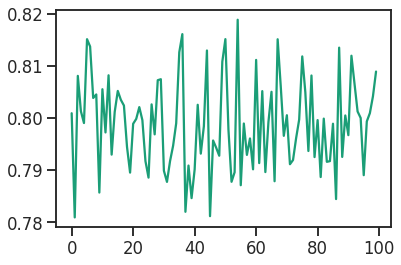

In [127]:
plt.plot(sim.temperature)

In [6]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF

box_length = np.cbrt(state.nparticles / state.density)
u = mda.Universe("trajectory.xtc", guess_bonds=False)
rdf = InterRDF(u.atoms, u.atoms, nbins=201, range=(1e-15, box_length/2))
rdf.run(0, 500);

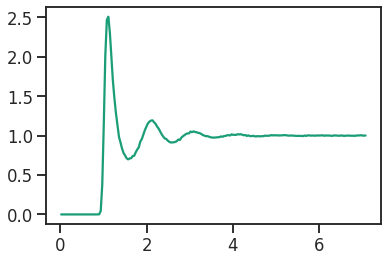

In [129]:
# plot g(r) versus r
r = rdf.results.bins
g = rdf.results.rdf

plt.plot(rdf.results.bins, rdf.results.rdf)

In [130]:
# compute the integrals for energy and pressure
# use the "cumulative_trapezoid" function
from scipy.integrate import simpson, cumulative_trapezoid, trapezoid

integrant_u = g * r**2 * 4 * (r**(-12) - r**(-6))
integrant_p = g * r**2 * 24 * (2 * r**(-12) - r**(-6))

u_c = cumulative_trapezoid(integrant_u, r, initial=0)
p_c = cumulative_trapezoid(integrant_p, r, initial=0)

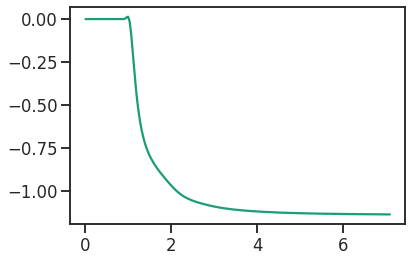

In [131]:
# plot the cumulative integrals
plt.plot(r, u_c)

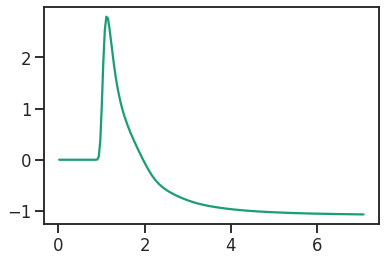

In [132]:
plt.plot(r, p_c)

In [133]:
# energy and pressure via g(r)
energy_g = 3.0 / 2.0 * state.temperature + 2.0 * np.pi * state.density * u_c[-1] 
pressure_g = state.density * state.temperature + 2 / 3 * np.pi * state.density**2 * p_c[-1]

In [134]:
# Simulation results and statistical uncertainties
from pymbar.timeseries import integratedAutocorrelationTime

energy_iat = integratedAutocorrelationTime(sim.total_energy, fast=True)
pressure_iat = integratedAutocorrelationTime(sim.pressure, fast=True)
iat = max((1, int(2.0 * energy_iat), int(2.0 * pressure_iat)))
energy_ci = 1.96 * sim.total_energy[::iat].sem(ddof=1) / state.nparticles
pressure_ci = 1.96 * sim.pressure[::iat].sem(ddof=1)

energy_simulation = sim.total_energy.mean() / state.nparticles 
pressure_simulation = state.density * state.temperature + sim.pressure.mean()

In [135]:
print(f'U / N (simulation) = {energy_simulation:8.4f} ± {energy_ci:.4f}')
print(f'U / N (rdf)        = {energy_g:8.4f}')
print(f'p     (simulation) = {pressure_simulation:8.4f} ± {pressure_ci:.4f}')
print(f'p     (rdf)        = {pressure_g:8.4f}')

U / N (simulation) =  -3.8323 ± 0.0047
U / N (rdf)        =  -3.7944
p     (simulation) =  -0.6465 ± 0.0359
p     (rdf)        =  -0.5370


## Isothermal compressibility for the truncated and shifted (TS) Lennard-Jones fluid

In what follows, we will work with the Lennard-Jones potential, truncated and shifted at $r_c = 2.5 \sigma$.
We will calculate the isothermal compressibility, $\kappa_T$ which defined as

\begin{align}
    \kappa_T = - \frac{1}{V} \left( \frac{\partial V}{\partial p} \right)_{T,N} 
\end{align}

The partial derivative in this equation can be estimated from multiple $N, V, T$ simulations at different densities.

An alternative route to compute this property from a *single* simulation can be achieved using the pair correlation function.

\begin{align}
    \kappa_T =\frac{1 + \rho G^\infty_O}{\rho k_B T}
\end{align}

where $G^\infty_O$ is the so-called *Kirkwood-Buff integral*, which is defined as

\begin{align}
    G^\infty_O = \int_0^\infty [g_O(r) - 1] 4 \pi r^2 \mathrm{d}r
\end{align}

Here, $g_O(r)$ denotes the pair correlation function in an $\mu, V, T$ ensemble ("o" stands for *open* ensemble, i.e. an ensemble with a fluctuating number of particles).

We will approximate $G^\infty_O$ (see [here](https://pubs.acs.org/doi/pdf/10.1021/jz301992u))

1. from a simulation in a closed ensemble
2. using a simulation at finite size.

\begin{align}
    G^\infty_O \approx G^R = \int_0^{2R} [g(r) -1] w(r, x) \mathrm{d}r
\end{align}

with 

\begin{align}
    w(r, x) &= 4 \pi r^2(1 - 3x/2 + x^3/2) \\
    x &= \frac{r}{2R}
\end{align}

so that

\begin{align}
    \kappa_T \approx \frac{1 + \rho G^R}{\rho k_B T}
\end{align}

$g(r)$ appearing in the above equation is the pari correlation function as obtained from an $N,V,T$ simulation.

---
### 2. Estimate $\kappa_T$ using the Kirkwood-Buff integral

- $\rho^* = 0.776$
- $T^* = 0.9$
- $r_c = 2.5$
- $N = 4000$
- $\Delta t^* = 0.01$

From PeTS (an equation of state): $\kappa_\text{T,PeTS}^* = 0.1$

In [4]:
simulation_parameters = SimulationParameters(dt=0.01, nequilibration=1000, nproduction=50_000)
sampling_parameters = SamplingParameters(nsample=10, ntrajectory=100, filename="trajectory_4000.xtc")
temperature = 0.9
state = State(4000, temperature=temperature, density=0.776)
rc = 2.5
thermostat = Thermostat.berendsen(temperature, simulation_parameters.dt, 1.25)
potential = Potential.lennard_jones(1.0, 1.0, rc, True, shift_at=rc)
# sim = nvt(state, rc, potential, thermostat, thermostat_frequency=1, simulation_parameters=simulation_parameters, sampling_parameters=sampling_parameters)

In [7]:
# compute rdf
box_length = np.cbrt(state.nparticles / state.density)
u = mda.Universe("trajectory_4000.xtc", guess_bonds=False)
#rdf = InterRDF(u.atoms, u.atoms, nbins=201, range=(1e-15, rc)) # box_length/2))
rdf = InterRDF(u.atoms, u.atoms, nbins=201, range=(1e-15, box_length/2))
rdf.run(0, 500);

r = rdf.results.bins
g = rdf.results.rdf

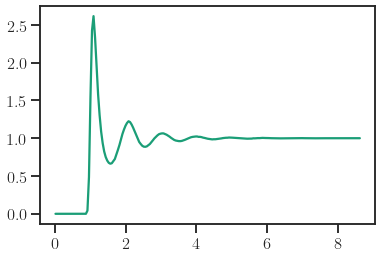

In [8]:
plt.plot(r, g)

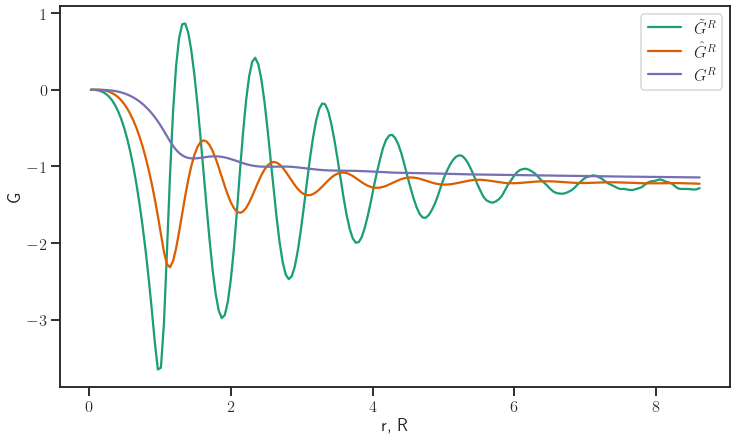

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(r, gr_tilde(g, r), label=r'$\tilde{G}^R$')
plt.plot(r, gr_hat(g, r), label=r'$\hat{G}^R$')
plt.plot(r, gr(g, r), label=r'$G^R$')
plt.ylabel('G')
plt.xlabel('r, R')
plt.legend(loc='best')

In [16]:
kappa_kb = (1 + state.density * gr_hat(g, r)[-1]) / (state.density * state.temperature)
kappa_kb

0.07038568538730701

---
### 3. Estimate $\kappa_T$ from multiple $NVT$ simulations.

- Perform simulations to compute the partial derivative $\left( \frac{\partial V}{\partial p} \right)_{T,N}$.
    - Formulate the above partial derivative in terms of the density.
    - Use a [5-point stencil](https://en.wikipedia.org/wiki/Five-point_stencil) to approximate the partial derivative
- Compute $\kappa_T$

In [233]:
h = 0.05
densities = state.density + np.array([-2*h, -h, h, 2*h, 0])
dfs = {}

for density in densities:
    s = State(500, temperature=temperature, density=density)
    sampling_parameters = SamplingParameters(nsample=100, ntrajectory=1000000, filename=f'traj_{density}.xtc')
    simulation_parameters = SimulationParameters(dt=0.01, nequilibration=10_000, nproduction=50_000)
    thermostat = Thermostat.berendsen(temperature, simulation_parameters.dt, 1.25)
    potential = Potential.lennard_jones(1.0, 1.0, rc, True, shift_at=rc)
    sim_i = nvt(s, rc, potential, thermostat, thermostat_frequency=1, simulation_parameters=simulation_parameters, sampling_parameters=sampling_parameters)
    dfs.update({density: sim_i})

Production   : 100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


In [234]:
df = pd.DataFrame([{'density': k, 'pressure': v.pressure.mean()} for k, v in dfs.items()])
df.set_index('density', inplace=True)
df

,pressure
density,
0.676,-1.009597
0.726,-0.845465
0.826,0.180025
0.876,1.173642
0.776,-0.454194


In [235]:
dp_drho = (-dfff.iloc[3].pressure + 8.0 * dfff.iloc[2].pressure - 8.0 * dfff.iloc[1].pressure + dfff.iloc[0].pressure) / (12 * h)
kappa_pd = 1 / dfff.index[-1] / dp_drho
kappa_pd

0.12505261817913288

## Equation of state

In [210]:
from feos_pets.si import *
from feos_pets import *
from feos_pets.eos import State as StatePets, Pets

eps_k = 119.8 * KELVIN
sigma = 3.405 * ANGSTROM
pr = PureRecord(Identifier("1"), 1, PetsRecord(sigma / ANGSTROM, eps_k / KELVIN))
parameters = PetsParameters.new_pure(pr)
eos = Pets(parameters)

t = temperature * eps_k
rho = state.density / sigma**3 / NAV

s_pets = StatePets(eos, temperature=t, density=rho, moles=SIArray1(1000 / NAV))
s_pets.pressure(Contributions.Total) / (KB * eps_k / sigma**3)

0.8725646466502514

In [205]:
dp_dv = s_pets.dp_dv() / (KB * eps_k / sigma**6)
v = s_pets.volume / sigma**3
kappa_pets = - 1.0 / v / dp_dv
kappa_pets

0.10298992405920558